### Batch Normalization with the MNIST Dataset

In [26]:
# Import necessary libraries

import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import matplotlib.pylab as plt
import numpy as np

# Set the manual seed for random number generation
torch.manual_seed(0)

#### Neural Network Module and Training Function

Define the neural network module or class 


In [27]:
# Define Neural Network Module with two hidden layers using Batch Normalization

class NetBatchNorm(nn.Module):
    
    # Constructor
    def __init__(self, in_size, n_hidden1, n_hidden2, out_size):
        super(NetBatchNorm, self).__init__()
        self.linear1 = nn.Linear(in_size, n_hidden1)
        self.linear2 = nn.Linear(n_hidden1, n_hidden2)
        self.linear3 = nn.Linear(n_hidden2, out_size)
        self.bn1 = nn.BatchNorm1d(n_hidden1)
        self.bn2 = nn.BatchNorm1d(n_hidden2)
        
        
    # Prediction
    def forward(self, x):
        x = self.bn1(torch.sigmoid(self.linear1(x)))
        x = self.bn2(torch.sigmoid(self.linear2(x)))
        x = self.linear3(x)
        return x
        
    
    # Activations to analyze results
    def activation(self, x):
        out = []
        z1 = self.bn1(self.linear1(x))
        out.append(z1.detach().numpy().reshape(-1))
        a1 = torch.sigmoid(z1)
        out.append(a1.detach().numpy().reshape(-1).reshape(-1))
        z2 = self.bn2(self.linear2(a1))
        out.append(z2.detach().numpy().reshape(-1))
        a2 = torch.sigmoid(z2)
        out.append(a2.detach().numpy().reshape(-1))
        return out

Neural Network Module with two hidden layers with out Batch Normalization


In [28]:
# Class Net for Neural Network Model

class Net(nn.Module):
    
    # Constructor
    def __init__(self, in_size, n_hidden1, n_hidden2, out_size):

        super(Net, self).__init__()
        self.linear1 = nn.Linear(in_size, n_hidden1)
        self.linear2 = nn.Linear(n_hidden1, n_hidden2)
        self.linear3 = nn.Linear(n_hidden2, out_size)
    
    # Prediction
    def forward(self, x):
        x = torch.sigmoid(self.linear1(x))
        x = torch.sigmoid(self.linear2(x))
        x = self.linear3(x)
        return x
    
    # Activations, to analyze results 
    def activation(self, x):
        out = []
        z1 = self.linear1(x)
        out.append(z1.detach().numpy().reshape(-1))
        a1 = torch.sigmoid(z1)
        out.append(a1.detach().numpy().reshape(-1).reshape(-1))
        z2 = self.linear2(a1)
        out.append(z2.detach().numpy().reshape(-1))
        a2 = torch.sigmoid(z2)
        out.append(a2.detach().numpy().reshape(-1))
        return out 


Define a function to train the model. In this case the function returns a Python dictionary to store the training loss and accuracy on the validation data 


In [29]:
# Function to train model

def train(model, criterion, train_loader, validation_loader, optimizer, epochs=100):
    useful_stuff = {'training_loss': [], 'validation_accuracy': []}

    for epoch in range(epochs):
        for i, (x, y) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            z = model(x.view(-1, 28*28))

            if z is None:
                print(f"Model returned None for input {x.view(-1, 28*28)}")
                continue

            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            useful_stuff['training_loss'].append(loss.data.item())

        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in validation_loader:
                model.eval()
                yhat = model(x.view(-1, 28*28))
                _, label = torch.max(yhat, 1)
                correct += (label == y).sum().item()
                total += x.shape[0]

        accuracy = 100 * (correct / total)
        useful_stuff['validation_accuracy'].append(accuracy)

    return useful_stuff

<h2 id="Makeup_Data">Make Some Data</h2> 


Load the training dataset by setting the parameters <code>train </code> to <code>True</code> and convert it to a tensor  by placing a transform object int the argument <code>transform</code>


In [30]:
# load the train dataset

train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

Load the validating dataset by setting the parameters train  <code>False</code> and convert it to a tensor by placing a transform object into the argument <code>transform</code>


In [31]:
# load the train dataset

validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

create the training-data loader and the validation-data loader object 


In [32]:
# Create Data Loader for both train and validating

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=2000, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000, shuffle=False)

#### Define Neural Network, Criterion function, Optimizer and Train the Model

Create the criterion function  


In [33]:
# Create the criterion function

criterion = nn.CrossEntropyLoss()

Variables for Neural Network Shape <code> hidden_dim</code> used for number of neurons in both hidden layers.


In [34]:
# Set the parameters

input_dim = 28 * 28
hidden_dim = 100
output_dim = 10

#### Train Neural Network using Batch Normalization and no Batch Normalization 

In [35]:
# Create model, optimizer and train the model with batch normalization

model_norm  = NetBatchNorm(input_dim, hidden_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model_norm.parameters(), lr = 0.1)


In [36]:
model_norm

NetBatchNorm(
  (linear1): Linear(in_features=784, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=10, bias=True)
  (bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [37]:
training_results_Norm=train(model_norm , criterion, train_loader, validation_loader, optimizer, epochs=5)

In [38]:
# Create model without Batch Normalization, optimizer and train the model

model = Net(input_dim, hidden_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)
training_results = train(model, criterion, train_loader, validation_loader, optimizer, epochs=5)

### Analyze Results

Compare the histograms of the activation for the first layer of the first sample, for both models.

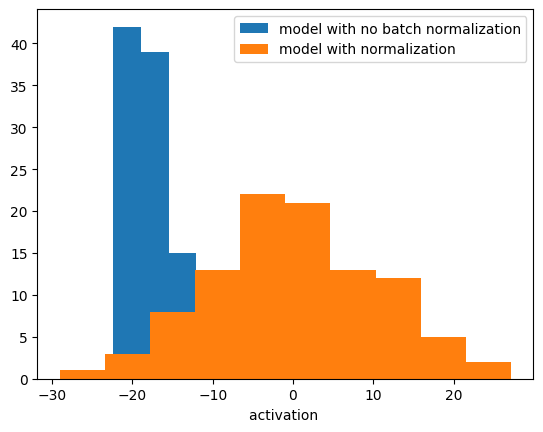

In [39]:
model.eval()
model_norm.eval()
out=model.activation(validation_dataset[0][0].reshape(-1,28*28))
plt.hist(out[2],label='model with no batch normalization' )
out_norm=model_norm.activation(validation_dataset[0][0].reshape(-1,28*28))
plt.hist(out_norm[2],label='model with normalization')
plt.xlabel("activation ")
plt.legend()
plt.show()

We see the activations with Batch Normalization are zero centred and have a smaller variance.

Compare the training loss for each iteration

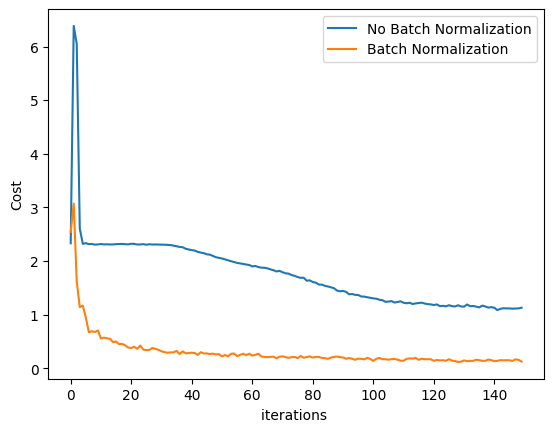

In [40]:
# Plot the diagram to show the loss

plt.plot(training_results['training_loss'], label='No Batch Normalization')
plt.plot(training_results_Norm['training_loss'], label='Batch Normalization')
plt.ylabel('Cost')
plt.xlabel('iterations ')   
plt.legend()
plt.show()

Compare the validating accuracy for each iteration

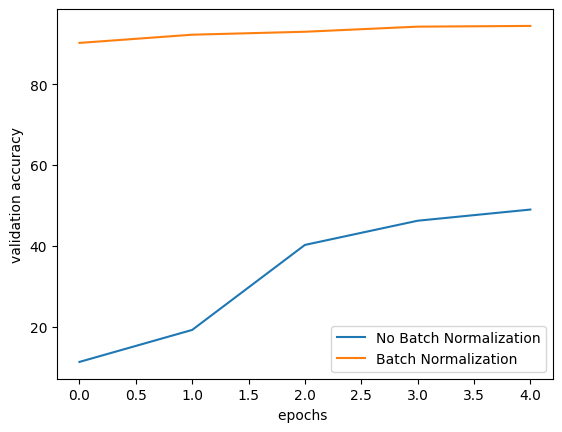

In [41]:
# Plot the diagram to show the accuracy

plt.plot(training_results['validation_accuracy'],label='No Batch Normalization')
plt.plot(training_results_Norm['validation_accuracy'],label='Batch Normalization')
plt.ylabel('validation accuracy')
plt.xlabel('epochs ')   
plt.legend()
plt.show()